## 이번엔 긍정 부정 키워드까지 한번에 뽑아보자

In [ ]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter
import plotly.graph_objects as go
import yfinance as yf
from PIL import Image
import numpy as np

# Connect to MySQL database
conn = mysql.connector.connect(
    host=#호스트,
    port=3306,
    user= #username,
    password= #password,
    database="antking"
)
cursor = conn.cursor(buffered=True)

/tmp/ipykernel_7382/532151583.py:24: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

/tmp/ipykernel_7382/532151583.py:27: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

[*********************100%%**********************]  1 of 1 completed


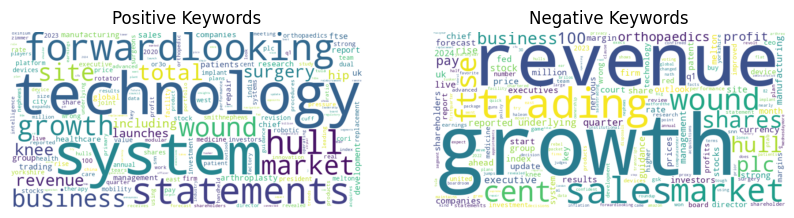

In [6]:
# Query data from the database
senti_query = "SELECT a.pub_date, s.sentiment_from_ctext, s.sentiment_from_keyword FROM article a, sentiment s WHERE a.id = s.article_id AND a.search_keyword = 'SNN' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_senti = pd.read_sql(senti_query, conn)

key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = 'SNN' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude
exclude_keywords = ['smith+nephew','smith & nephew', 'smithnephew','nephew','smith', 'robot', 'medical', 'surgical', 'company', 'robotics']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Combine sentiment and keyword data
df_combined = pd.merge(df_senti, df_words, on='pub_date')

# Filter keywords by sentiment
positive_keywords = df_combined[df_combined['sentiment_from_ctext'] == 'positive']['words']
# positive_keywords = df_combined[df_combined['sentiment_from_keyword'] == 'positive']['words']
negative_keywords = df_combined[df_combined['sentiment_from_ctext'] == 'negative']['words']
# negative_keywords = df_combined[df_combined['sentiment_from_keyword'] == 'negative']['words']

# Count word frequencies for positive and negative sentiments
positive_word_freq = Counter(positive_keywords)
negative_word_freq = Counter(negative_keywords)

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_word_freq)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_word_freq)

# Fetch stock price data
company = 'SNN'
ticker_symbol = company
start_date = '2020-01-01'
end_date = '2024-05-01'
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Calculate mean closed price by date
mean_closed_price = stock_data['Adj Close'].groupby(stock_data.index.date).mean()

# Prepare data for sentiment analysis bar chart
df_agg = df_senti.groupby(['pub_date', 'sentiment_from_ctext']).size().unstack(fill_value=0)
dates = df_agg.index
positive = df_agg.get('positive', 0)
neutral = df_agg.get('neutral', 0)
negative = df_agg.get('negative', 0)

# Create Plotly figure
fig = go.Figure()

# Add traces for positive, neutral, and negative sentiments
fig.add_trace(go.Bar(
    x=dates,
    y=positive,
    name='Positive',
    marker_color='green',
    width=0.4,
    opacity=0.8,
    marker_line_width=1.5,
    marker_line_color='green',
    offsetgroup=0
))

fig.add_trace(go.Bar(
    x=dates,
    y=neutral,
    name='Neutral',
    marker_color='gray',
    width=0.4,
    opacity=0.8,
    marker_line_width=1.5,
    marker_line_color='black',
    offsetgroup=0
))

fig.add_trace(go.Bar(
    x=dates,
    y=-negative,  # Negative sentiment is shown below the baseline
    name='Negative',
    marker_color='red',
    width=0.4,
    opacity=0.8,
    marker_line_width=1.5,
    marker_line_color='red',
    offsetgroup=0
))

# Add trace for mean closed price
fig.add_trace(go.Scatter(
    x=mean_closed_price.index,
    y=mean_closed_price,
    mode='lines',
    name='Mean Closed Price',
    line=dict(color='blue', width=2),
    yaxis='y2'
))

# Update layout to combine both plots and adjust y-axis range
fig.update_layout(
    title=f'Sentiment Analysis and Mean Closed Price of Smith & Nephew. ({company})',
    xaxis_title='Date',
    yaxis_title='Sentiment Count',
    yaxis2=dict(
        title='Mean Closed Price',
        overlaying='y',
        side='right',
        showgrid=False,
        titlefont=dict(
            color='blue',
            size=10
        ),
        tickfont=dict(
            color='blue',
            size=10
        )
    ),
    template='plotly_white',
)

# Show the Plotly figure
fig.show()

# Plot the word clouds
plt.figure(figsize=(10, 5))

# Positive keywords word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Keywords')

# Negative keywords word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Keywords')

plt.show()


꽤 유의미한 결과값을 보이는 듯 하다. 이번엔 아예 워드클라우드만 쫙 뽑아보자

# wordcloud 활용

## 한국 기업별 워드 클라우드

### 고영

/tmp/ipykernel_9699/4016071196.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_key = pd.read_sql(key_query, conn)


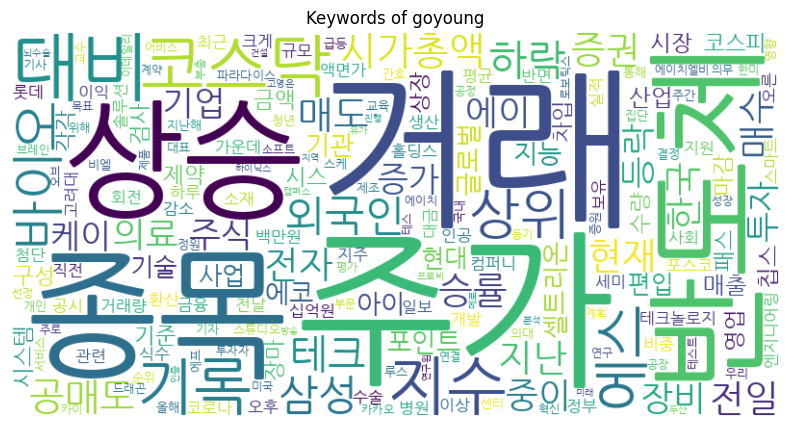

In [22]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database

# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = '고영' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
# df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['고영', '고광일', '로봇']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # Change to the path of a Korean font on your system
                      width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of goyoung')
plt.show()


### 큐렉소

/tmp/ipykernel_9699/1954928873.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_key = pd.read_sql(key_query, conn)


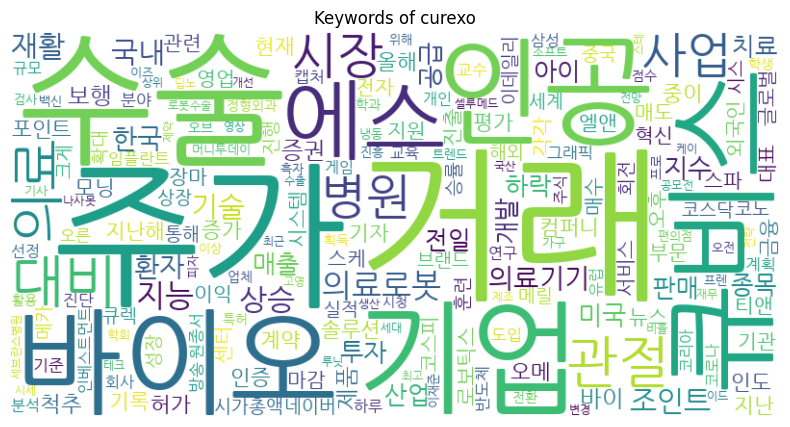

In [15]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database

# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = '큐렉소' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
# df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['큐렉소', '로봇']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # Change to the path of a Korean font on your system
                      width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of curexo')
plt.show()


### 미래컴퍼니

/tmp/ipykernel_7382/2483156997.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_key = pd.read_sql(key_query, conn)


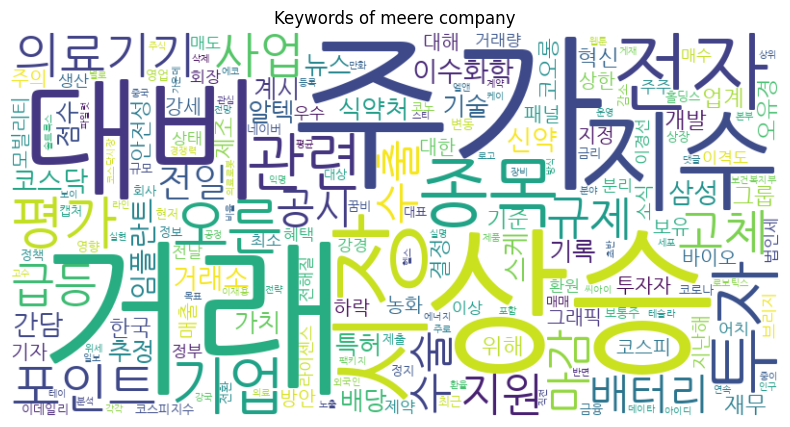

In [1]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database


# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = '미래컴퍼니' AND a.pub_date between '2023-02-27' and '2023-03-06';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['미래', '컴퍼니', '로봇', '에스']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # Change to the path of a Korean font on your system
                      width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of meere company')
plt.show()


## 한국 "의료 로봇" 결과

/tmp/ipykernel_9699/1286651387.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_key = pd.read_sql(key_query, conn)


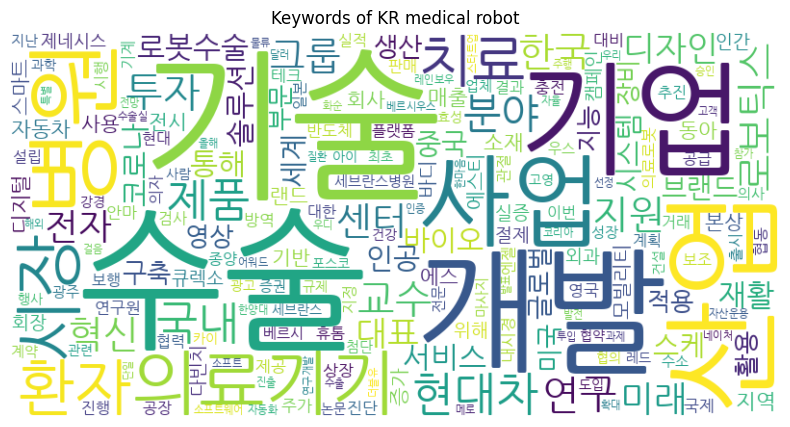

In [25]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database

# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = '의료용 로봇' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['의료', '로봇']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # Change to the path of a Korean font on your system
                      width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of KR medical robot')
plt.show()


## 미국 "medical robot OR surgical robot" 결과

/tmp/ipykernel_7382/3822125185.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_key = pd.read_sql(key_query, conn)


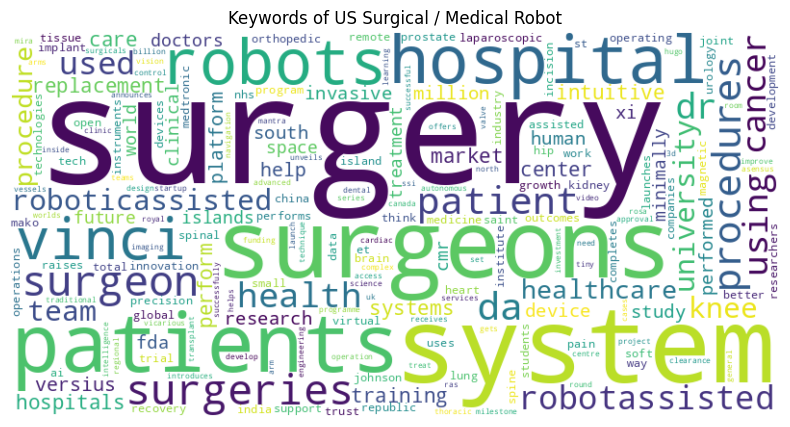

In [4]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database

# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = 'surgical robot OR medical robot' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['surgical', 'company', 'medical', 'technology', 'robotics', 'robotic', 'robot']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of US Surgical / Medical Robot')
plt.show()


## 미국 기업별 워드클라우드

뭔가 미국은 확실히 유의미한 단어가 나오는듯하다

In [37]:
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = 'MDT' AND a.pub_date between '2021-09-04' and '2021-11-30';"
df_key = pd.read_sql(key_query, conn)

df_key

/tmp/ipykernel_9699/1615160815.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



pub_date  article_id                                        keyword_set
0    2021-09-08       11072  'treatment' 'lung' 'malignant' 'study' 'ablati...
1    2021-09-09       11073  'shrinks' 'wirefree' 'device' 'enlarging' 'mic...
2    2021-09-09       11074  'hospitals' 'corin' 'growing' 'group' 'spine' ...
3    2021-09-10       11075  'care' 'state' 'technology' 'valuebased' 'tech...
4    2021-09-10       11076  'builds' 'study' 'results' 'trial' 'hypertensi...
..          ...         ...                                                ...
132  2021-11-26       11204  'sensor' 'sensors' 'chain' 'disrupted' 'tempor...
133  2021-11-30       11205  'intelligent' 'health' 'intelligence' 'ai' 'gi...
134  2021-11-30       11206  'licenses' 'uses' 'license' 'gi' 'increase' 'c...
135  2021-11-30       11207  'job' 'southeast' 'looking' 'ricos' 'windowcli...
136  2021-11-30       11208  'pillcam' 'addition' 'source' 'system' 'newest...

[137 rows x 3 columns]

In [38]:
df_key['words'] = df_key['keyword_set'].str.split()

df_words = df_key.explode('words')

# df_words['words'] = df_words['words'].str.replace("[", "")
# df_words['words'] = df_words['words'].str.replace("]", "")
# df_words['words'] = df_words['words'].str.replace(",", "")
df_words['words'] = df_words['words'].str.replace("'", "")

df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']
df_words['words']

0      treatment
0           lung
0      malignant
0          study
0       ablation
         ...    
136    endoscopy
136         rate
136       second
136       remote
136          sb3
Name: words, Length: 2016, dtype: object

### medtronic

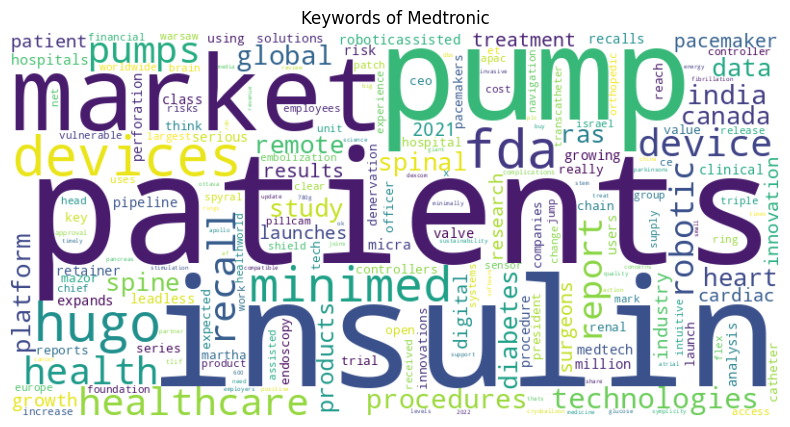

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# List of keywords to exclude
exclude_keywords = ['system','surgery','technology','medtronic', 'medtronics', 'robot', 'medical', 'surgical', 'company', 'robotics', 'business']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

word_freq = df_words['words'].value_counts()

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of Medtronic')
plt.show()

In [41]:
key_query = """SELECT a.pub_date, a.title, k.keyword_set, s.sentiment_from_ctext, 
                s.sentiment_from_keyword FROM article a, keyword k, sentiment s 
                WHERE a.id = k.article_id AND a.id = s.article_id AND a.search_keyword = 'MDT'
                AND a.pub_date between '2021-03-26' and '2021-05-04' AND keyword_set like '%device%';"""
df_key = pd.read_sql(key_query, conn)

df_key['sentiment_from_ctext'].value_counts()
df_key['sentiment_from_keyword'].value_counts()

/tmp/ipykernel_9699/2410657281.py:5: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



sentiment_from_keyword
positive    8
negative    4
Name: count, dtype: int64

### johnson and johnson

/tmp/ipykernel_5217/3466464752.py:20: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



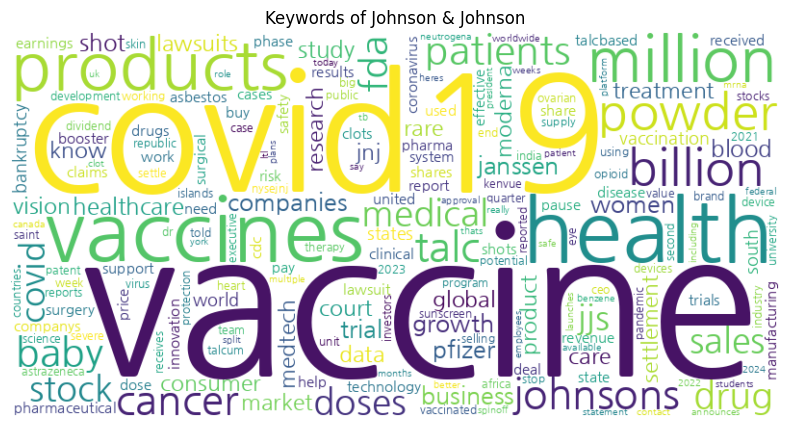

In [510]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database


# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = 'JNJ' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['johnson', 'jj', 'company']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # Change to the path of a Korean font on your system
                      width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of Johnson & Johnson')
plt.show()


### smith & nephew

/tmp/ipykernel_5217/204318947.py:20: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



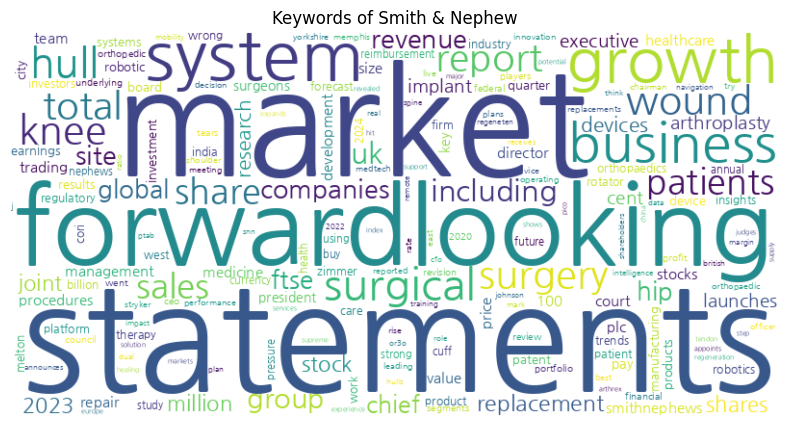

In [512]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database

# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = 'SNN' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['smithnephew', 'smith', 'nephew', 'medical', 'technology', 'company']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # Change to the path of a Korean font on your system
                      width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of Smith & Nephew')
plt.show()


### asensus surgical

/tmp/ipykernel_5217/4143990005.py:20: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



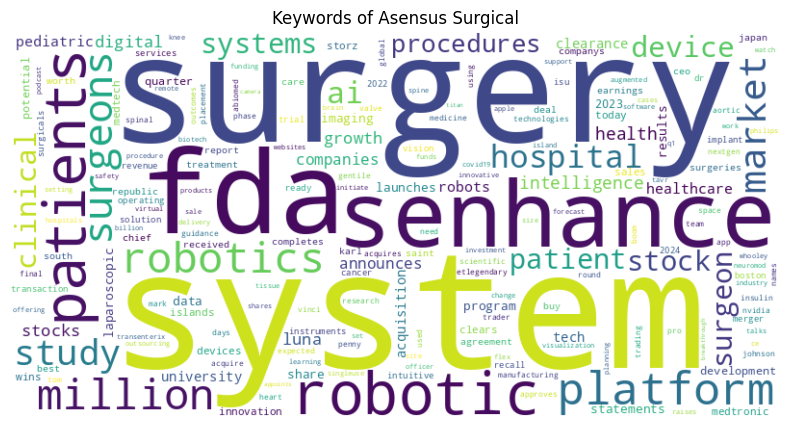

In [515]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database


# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = 'ASXC' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['asensus', 'surgical', 'company', 'medical', 'technology', 'robot']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of Asensus Surgical')
plt.show()


### globus medical

/tmp/ipykernel_5217/179718646.py:20: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



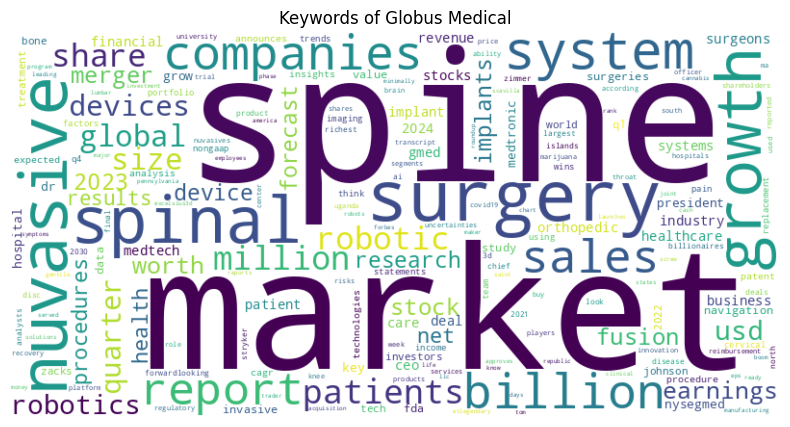

In [518]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database


# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = 'GMED' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['globus', 'medical', 'surgical', 'company', 'medical', 'technology', 'robot']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of Globus Medical')
plt.show()


### intuitive surgical

/tmp/ipykernel_5217/1267520898.py:20: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



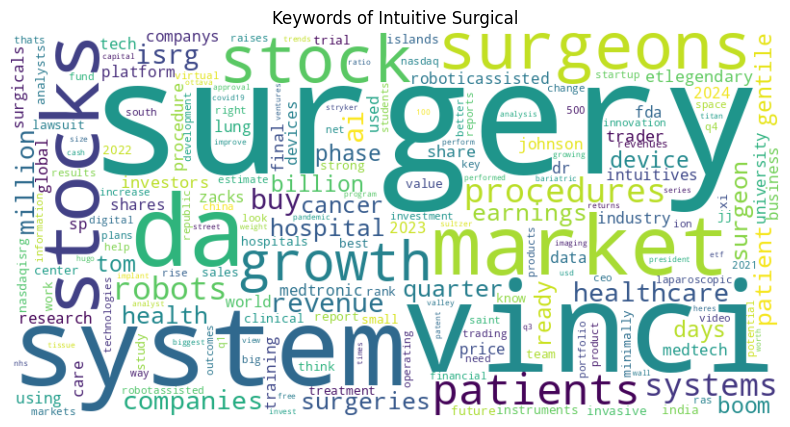

In [522]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database


# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = 'ISRG' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['intuitive', 'medical', 'surgical', 'company', 'medical', 'technology', 'robot', 'robotic','robotics']  # Replace with the keywords you want to exclude

# Filter out the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of Intuitive Surgical')
plt.show()


### stryker corporation

/tmp/ipykernel_5217/1681684788.py:20: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



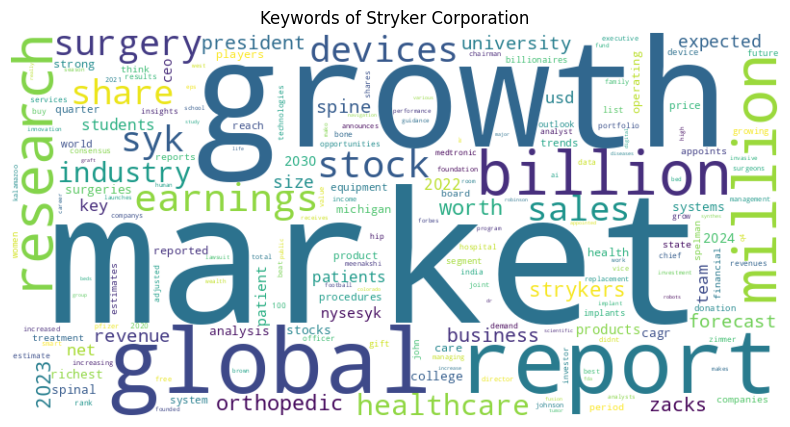

In [524]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

# Connect to MySQL database


# Query data from the database
key_query = "SELECT a.pub_date, k.article_id, k.keyword_set FROM article a, keyword k WHERE a.id = k.article_id AND a.search_keyword = 'SYK' AND a.pub_date between '2020-01-01' and '2024-06-01';"
df_key = pd.read_sql(key_query, conn)

# Split keyword_set into individual words
df_key['words'] = df_key['keyword_set'].str.split()

# Explode the DataFrame to have one word per row
df_words = df_key.explode('words')
df_words['words'] = df_words['words'].str.replace(",", "")
# df_words['words'] = df_words['words'].str.replace("[", "") #필요할 경우에만 쓰면 됨
# df_words['words'] = df_words['words'].str.replace("]", "")
df_words['words'] = df_words['words'].str.replace("'", "")

# Drop rows with NaN values or empty strings
df_words.dropna(subset=['words'], inplace=True)
df_words = df_words[df_words['words'] != '']

# List of keywords to exclude (if any)
exclude_keywords = ['stryker', 'corporation', 'medical', 'surgical', 'company', 'medical', 'technology', 'robot', 'robotic','robotics']  # Replace with the keywords you want to exclude

# Filter ou'neutral': 'gray', t the excluded keywords
df_words = df_words[~df_words['words'].isin(exclude_keywords)]

# Initialize the Okt tokenizer
okt = Okt()

# Tokenize and normalize the words
df_words['words'] = df_words['words'].apply(lambda x: okt.normalize(x))

# Count word frequencies
word_freq = Counter(df_words['words'])

# Generate a word cloud with a font that supports Korean
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of Stryker Corporation')
plt.show()
